# Dataset Description

- This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.
- The goal of this project is to segments customers then find the characteristics of each segments

In [983]:
#Import Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import winsorize
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


In [984]:
#Create function for plotting
def pair_plot(data, model):
    data['label'] = model.labels_
    sns.pairplot(data, hue='label', palette='bright')

In [991]:
df = pd.read_csv(r'C:\Users\lehon\Documents\casestudydata\Python projects\E-commerce.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom


# Feture engineering

In [996]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [995]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

After take a look into our data there is some columns that have null values for CustomerID column we will group it to calculate further so no need for handle them, for the Description column we will not use this colunm for customer segmentations.

In [856]:
subdf = df.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].sum().reset_index()
Return_transaction=[]
for i in subdf['InvoiceNo']:
    if i[0] == 'C':
        Return_transaction.append(1)
    else:
        Return_transaction.append(0)

In [857]:
subdf['Return_transaction'] = Return_transaction
Return = subdf.groupby('CustomerID')['Return_transaction'].sum().reset_index()
Return

,CustomerID,Return_transaction
0,12346.0,1
1,12347.0,0
2,12348.0,0
3,12349.0,0
4,12350.0,0
...,...,...
4367,18280.0,0
4368,18281.0,0
4369,18282.0,1
4370,18283.0,0


In [858]:
#Calculate customer behavior related metrics
df['Total_spend'] = df.Quantity * df.UnitPrice
df1 = df.groupby('CustomerID')['Total_spend'].sum().reset_index()

In [862]:
#Calculate customer behavior related metrics
df.InvoiceDate = pd.to_datetime(df.InvoiceDate).dt.date
CustomerInfo = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (x.max() - x.min()).days,
    'InvoiceNo': 'nunique',
    'StockCode': 'count'
}).reset_index().rename(columns={'InvoiceDate':'Customer_lifespan', 'InvoiceNo':'Num_of_transaction', 'StockCode': 'Num_of_products'})

In [863]:
#Calculate customer behavior related metrics
df1 = df1.merge(CustomerInfo, on='CustomerID', how='left')
df1['Average_order_value'] = df1['Total_spend'] / df1['Num_of_transaction']
df1 = df1.merge(Return, on='CustomerID', how='left')

In [875]:
#Calculate customer behavior related metrics
df1['Transaction_per_day'] = (df1.Num_of_transaction - df1.Return_transaction) / df1.Customer_lifespan
df1.Transaction_per_day = df1.Transaction_per_day.replace([np.inf, -np.inf], 0)
df1['Real_transaction'] = df1.Num_of_transaction - df1.Return_transaction
df1.Transaction_per_day = df1.Transaction_per_day.fillna(0)
df1.head()

,CustomerID,Total_spend,Customer_lifespan,Num_of_transaction,Num_of_products,Average_order_value,Return_transaction,Transaction_per_day,Real_transaction
0,12346.0,0.00,0,2,2,0.000000,1,0.000000,1
1,12347.0,4310.00,365,7,182,615.714286,0,0.019178,7
2,12348.0,1797.24,283,4,31,449.310000,0,0.014134,4
3,12349.0,1757.55,0,1,73,1757.550000,0,0.000000,1
4,12350.0,334.40,0,1,17,334.400000,0,0.000000,1


In [876]:
df2 = df1.drop(['CustomerID'], axis=1)
df2.head()

,Total_spend,Customer_lifespan,Num_of_transaction,Num_of_products,Average_order_value,Return_transaction,Transaction_per_day,Real_transaction
0,0.00,0,2,2,0.000000,1,0.000000,1
1,4310.00,365,7,182,615.714286,0,0.019178,7
2,1797.24,283,4,31,449.310000,0,0.014134,4
3,1757.55,0,1,73,1757.550000,0,0.000000,1
4,334.40,0,1,17,334.400000,0,0.000000,1


# Preprocessing data

In [877]:
mm = MinMaxScaler()
df2_scaled = mm.fit_transform(df2)
final_data  = pd.DataFrame(df2_scaled, columns=mm.get_feature_names_out())

In [878]:
final_data.head()

,Total_spend,Customer_lifespan,Num_of_transaction,Num_of_products,Average_order_value,Return_transaction,Transaction_per_day,Real_transaction
0,0.015109,0.000000,0.004049,0.000125,0.408529,0.021277,0.000000,0.004762
1,0.030297,0.978552,0.024291,0.022676,0.467194,0.000000,0.003196,0.033333
2,0.021442,0.758713,0.012146,0.003758,0.451339,0.000000,0.002356,0.019048
3,0.021303,0.000000,0.000000,0.009020,0.575989,0.000000,0.000000,0.004762
4,0.016288,0.000000,0.000000,0.002005,0.440390,0.000000,0.000000,0.004762


# Applying Models

Text(0, 0.5, 'inertia')

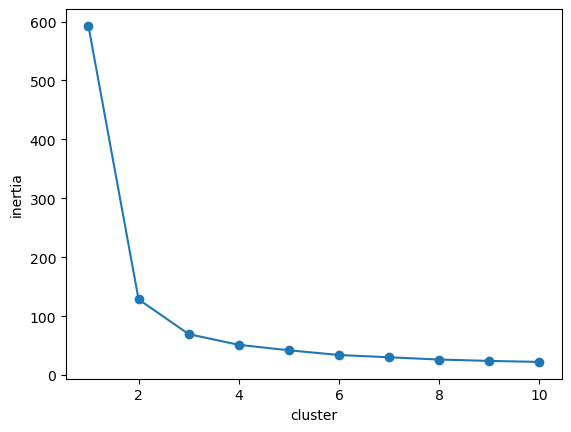

In [879]:
#Find the best cluster for KMeans using elbow method
inertia = []
for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(final_data)
    inertia.append(km.inertia_)
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('cluster')
plt.ylabel('inertia')

As can be seen the inertia stop drop significantly at n_cluster=2 so this should be our optimal point

In [880]:
km = KMeans(n_clusters=2)
km.fit(final_data)

KMeans(n_clusters=2)

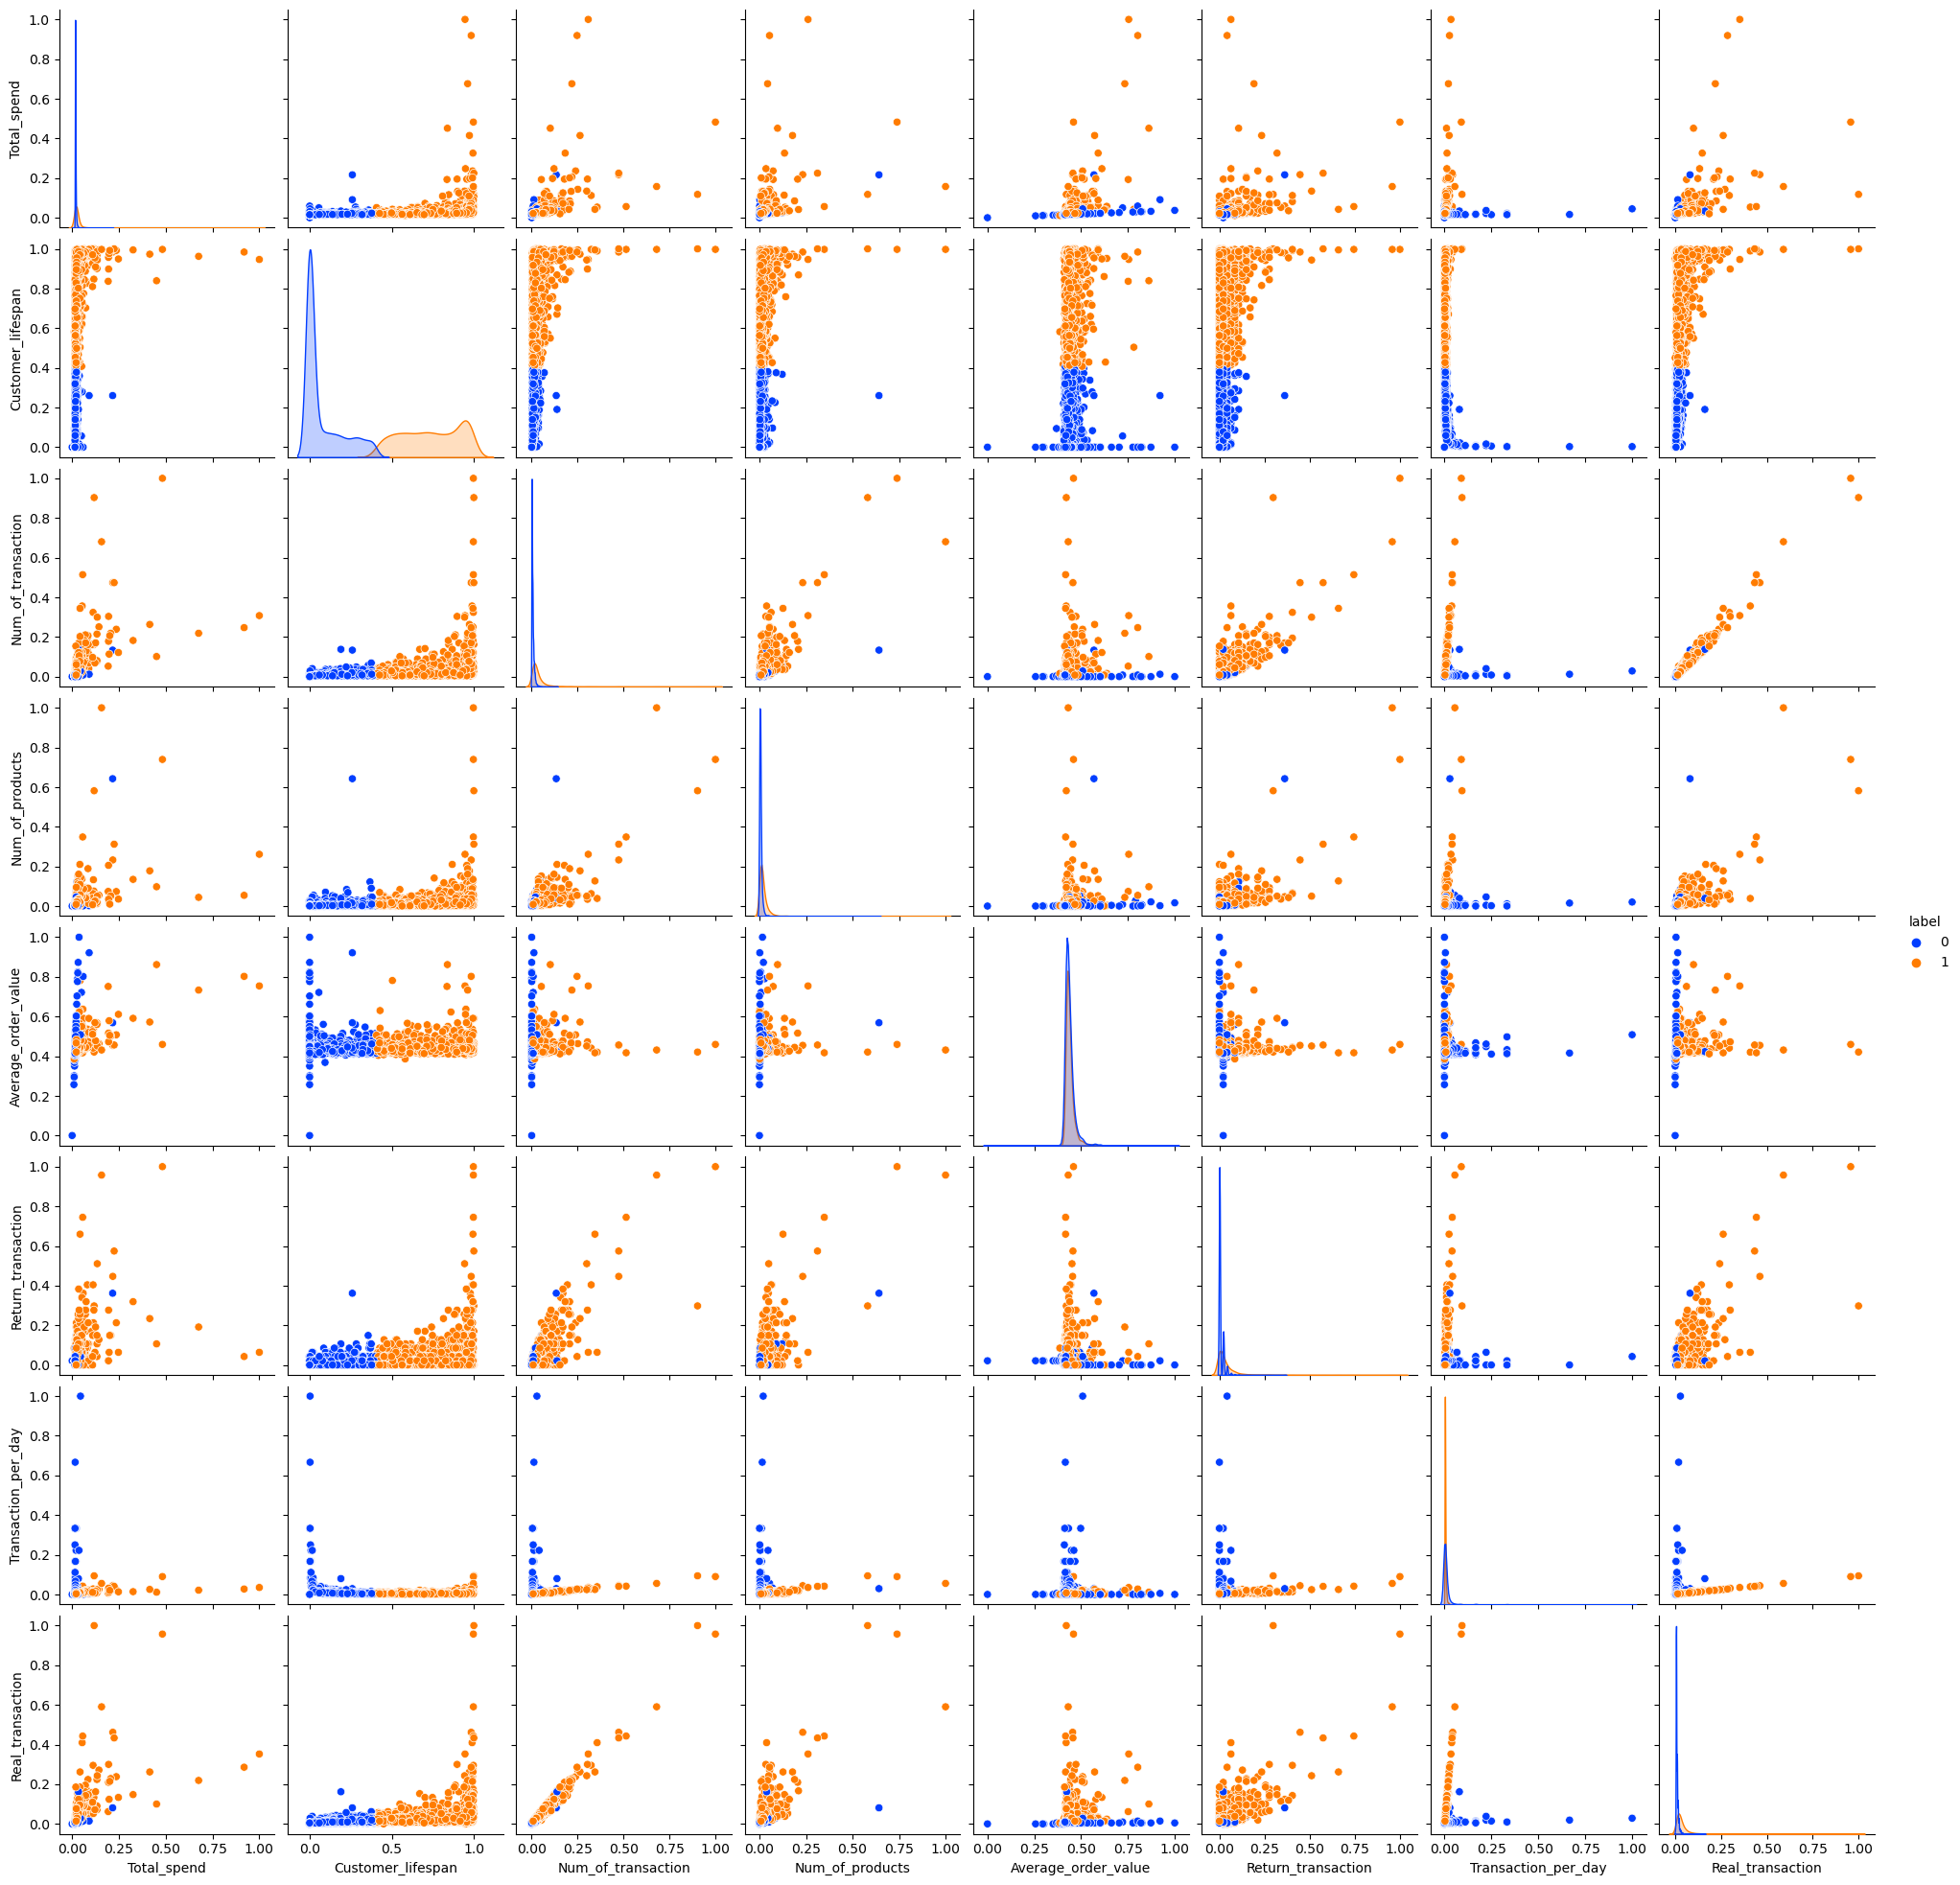

In [985]:
#Check the distribution of the data after labeling
pair_plot(final_data, km)

In [887]:
final_data['label'] = km.labels_

In [986]:
silhouette_score(final_data, km.labels_)

0.8477328927960921

silhouette_score range from -1 indicate that the labeling is doing very bad to 1 mean the labeling clustering the data well in this case it's 0.84 which is very good for our customer segmentation

# Dive deep into each cluster

In [889]:
inverse = pd.DataFrame(mm.inverse_transform(final_data.iloc[:,:-1]), columns=mm.get_feature_names_out())
analyse_data = round(pd.concat([inverse, final_data.iloc[:,-1]], axis=1),2)
analyse_data.head()

,Total_spend,Customer_lifespan,Num_of_transaction,Num_of_products,Average_order_value,Return_transaction,Transaction_per_day,Real_transaction,label
0,0.00,0.0,2.0,2.0,0.00,1.0,0.00,1.0,0
1,4310.00,365.0,7.0,182.0,615.71,0.0,0.02,7.0,1
2,1797.24,283.0,4.0,31.0,449.31,0.0,0.01,4.0,1
3,1757.55,0.0,1.0,73.0,1757.55,0.0,0.00,1.0,0
4,334.40,0.0,1.0,17.0,334.40,0.0,0.00,1.0,0


In [890]:
analyse_data.groupby('label').agg({
    'Total_spend': ['mean', 'median', 'std'],
    'Customer_lifespan': ['mean', 'median', 'std'],
    'Num_of_transaction': ['mean', 'median', 'std'],
    'Num_of_products': ['mean', 'median', 'std'],
    'Average_order_value': ['mean', 'median', 'std'],
    'Return_transaction': ['mean', 'median', 'std'],
    'Transaction_per_day': ['mean', 'median', 'std'],
    'Real_transaction': ['mean', 'median', 'std']
}).T.round(2)

label                             0         1
Total_spend         mean     620.44   3613.21
                    median   351.11   1582.60
                    std     1451.09  12259.27
Customer_lifespan   mean      29.14    274.04
                    median     0.00    276.00
                    std       44.34     66.45
Num_of_transaction  mean       2.04      9.15
                    median     1.00      6.00
                    std        1.86     13.06
Num_of_products     mean      41.04    162.85
                    median    23.00     98.00
                    std      115.38    316.58
Average_order_value mean     306.95    327.87
                    median   223.88    251.81
                    std      386.90    323.34
Return_transaction  mean       0.29      1.57
                    median     0.00      1.00
                    std        0.72      3.01
Transaction_per_day mean       0.05      0.03
                    median     0.00      0.02
                    std        0.21      0.03
Real_transaction    mean       1.75      7.58
                    median     1.00      5.00
                    std        1.46     10.77

After some grouping as can be seen in the dataframe label 1 have metrics in total_spend, lifespan,... is doing much better than the label 0. Label 1 can be assigned as engaging customers and label 0 can be assigned as non-engaging customers. 

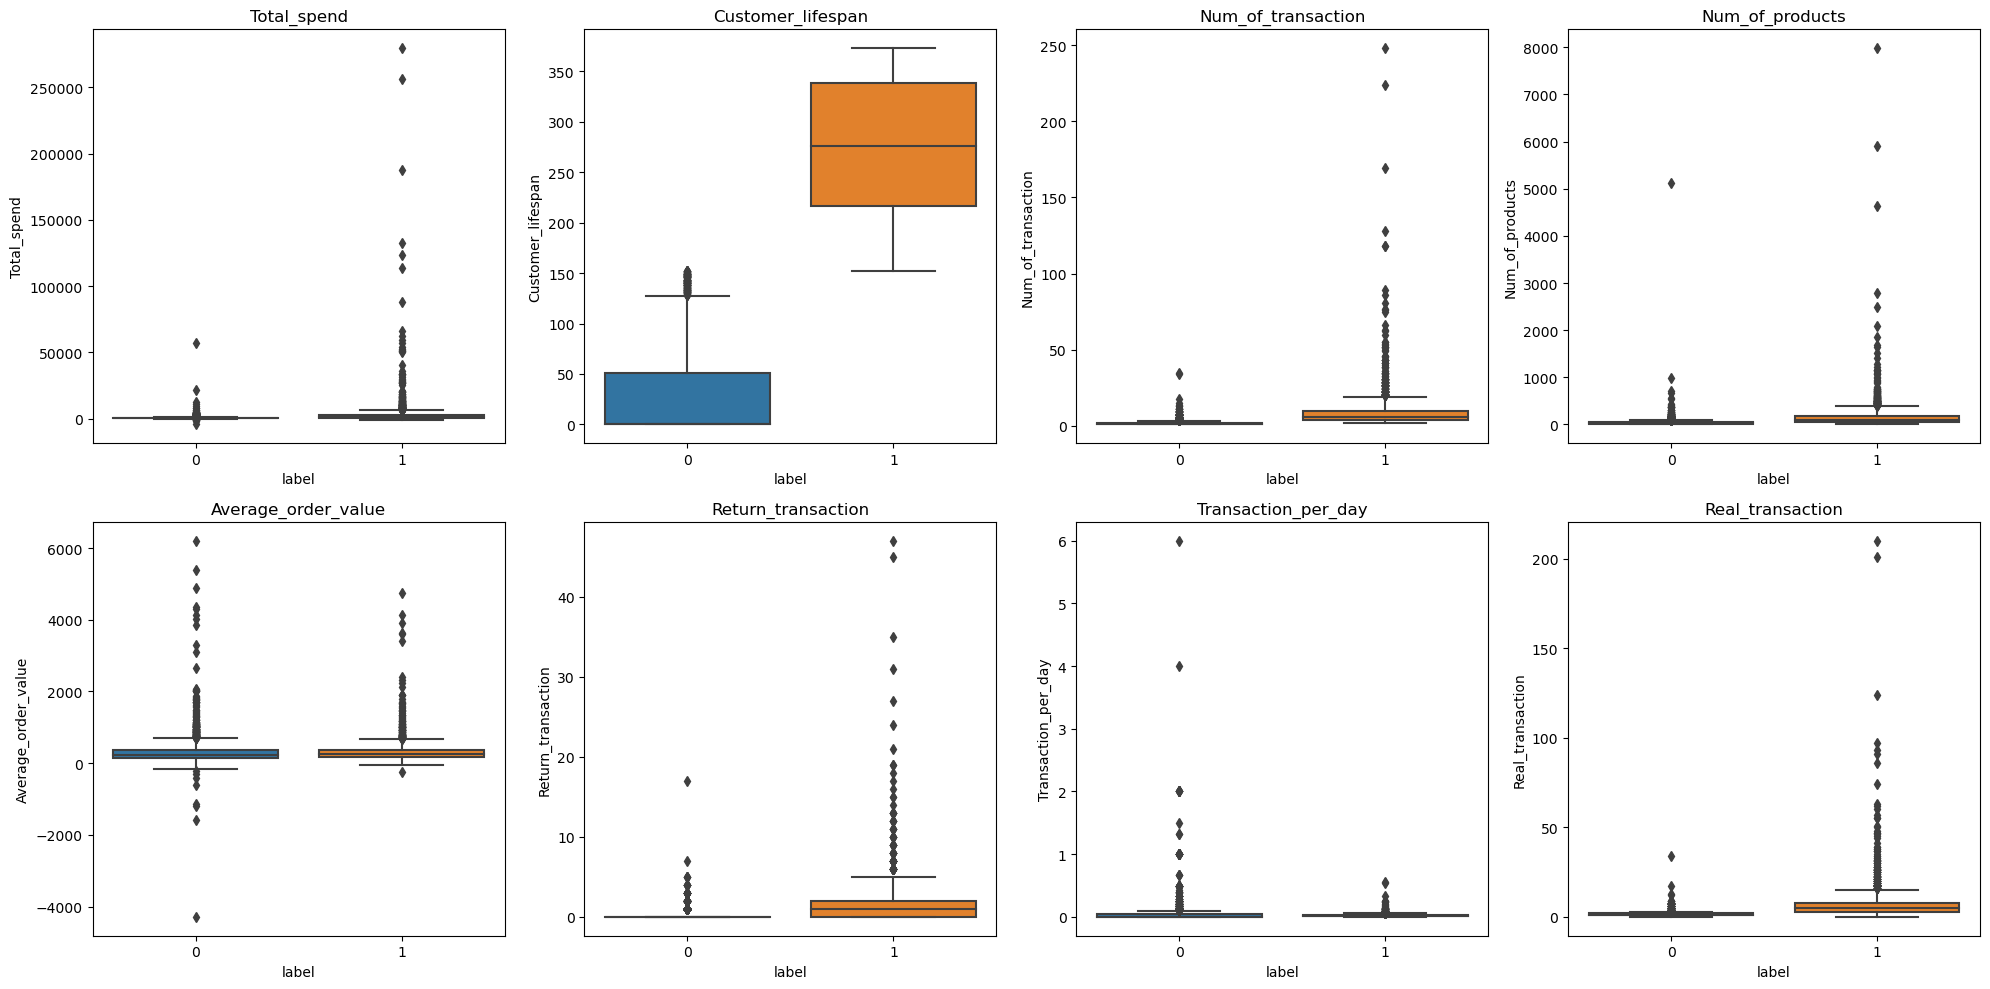

In [891]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(20,10)
for i,v in zip(analyse_data.columns, ax.flatten()):
    sns.boxplot(y= analyse_data[i], x=analyse_data['label'], ax=v)
    v.set_title(i)
    plt.tight_layout()

We visualize each clusters using boxplot but it seem to be affected by outliers a lot 

In [892]:
#Procced to treat outliers with winsorize
winsorize_data = pd.DataFrame()
for i in analyse_data.columns:
    winsorize_data[i] = winsorize(analyse_data[i], limits=[0.05,0.05])

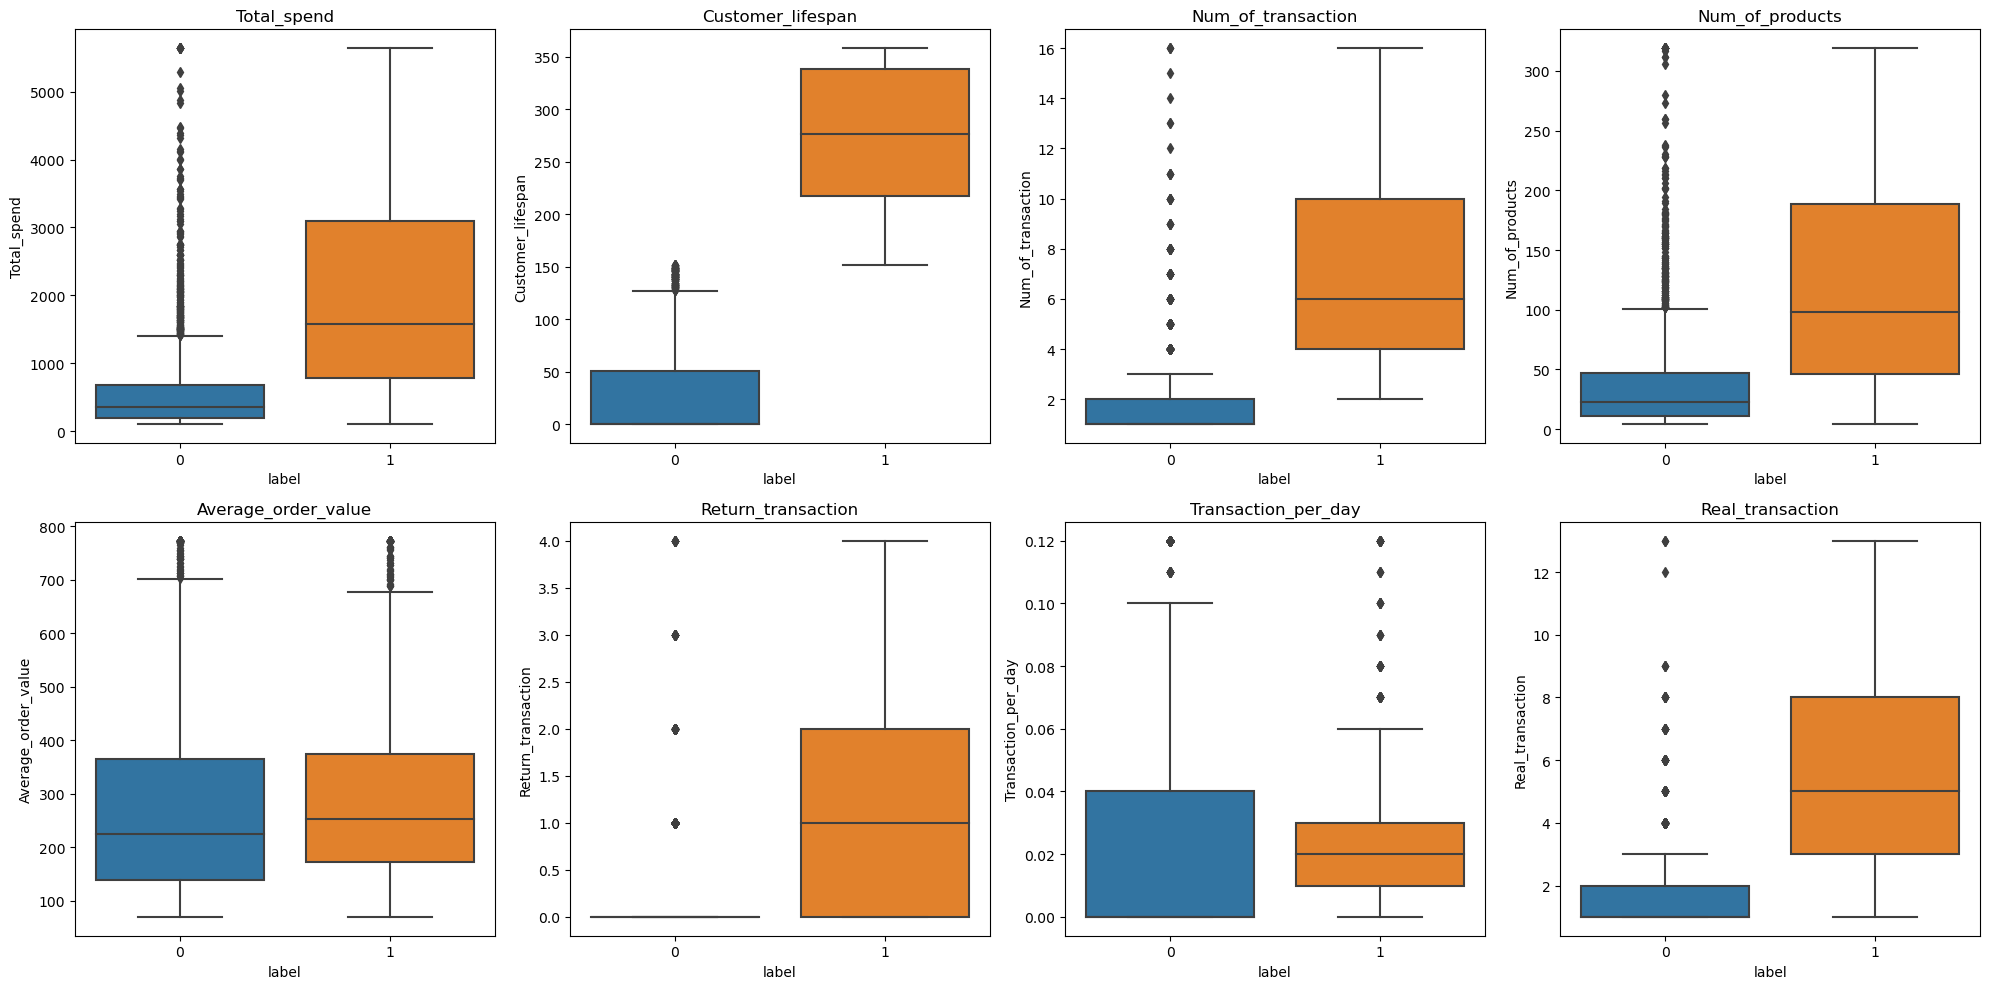

In [893]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(20,10)
for i,v in zip(winsorize_data.columns, ax.flatten()):
    sns.boxplot(y= winsorize_data[i], x=winsorize_data['label'], ax=v)
    v.set_title(i)
    plt.tight_layout()

Now we can see the distribution in each clusters much clearer

In [894]:
#Check the correlation of each feature with label
correlation = analyse_data.corrwith(analyse_data['label'])[:-1].sort_values()

Text(0.5, 1.0, 'Correlation with label')

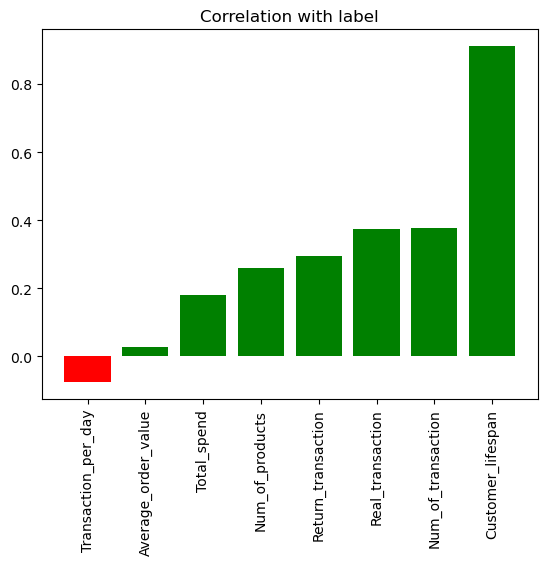

In [988]:
c = ['green' if i > 0 else 'red' for i in correlation]
plt.bar(correlation.index, correlation.values, color=c)
plt.xticks(rotation=90)
plt.title('Correlation with label')

We can see that apart from Transaction_per_day other feature have a positive relationship with the label which mean the higher the features are the higher chance that the customer belong to cluster 1 which is engaging customers. For the negative relationship of Transaction_per_day this is because we also counted the cancel transactions that make the Transaction_per_day to have inverse relationship with the label and this totally make sense

In [972]:
merger = df.groupby(['CustomerID', 'Country']).UnitPrice.sum().reset_index()
merger = merger.drop_duplicates(subset='CustomerID')
analyse_data1 = pd.concat([df1['CustomerID'],analyse_data], axis=1)
analyse_data1 = analyse_data1.merge(merger, on='CustomerID', how='left')
analyse_data1.head()

,CustomerID,Total_spend,Customer_lifespan,Num_of_transaction,Num_of_products,Average_order_value,Return_transaction,Transaction_per_day,Real_transaction,label,Country,UnitPrice
0,12346.0,0.00,0.0,2.0,2.0,0.00,1.0,0.00,1.0,0,United Kingdom,2.08
1,12347.0,4310.00,365.0,7.0,182.0,615.71,0.0,0.02,7.0,1,Iceland,481.21
2,12348.0,1797.24,283.0,4.0,31.0,449.31,0.0,0.01,4.0,1,Finland,178.71
3,12349.0,1757.55,0.0,1.0,73.0,1757.55,0.0,0.00,1.0,0,Italy,605.10
4,12350.0,334.40,0.0,1.0,17.0,334.40,0.0,0.00,1.0,0,Norway,65.30


Text(0.5, 1.0, 'Number of customer each countries')

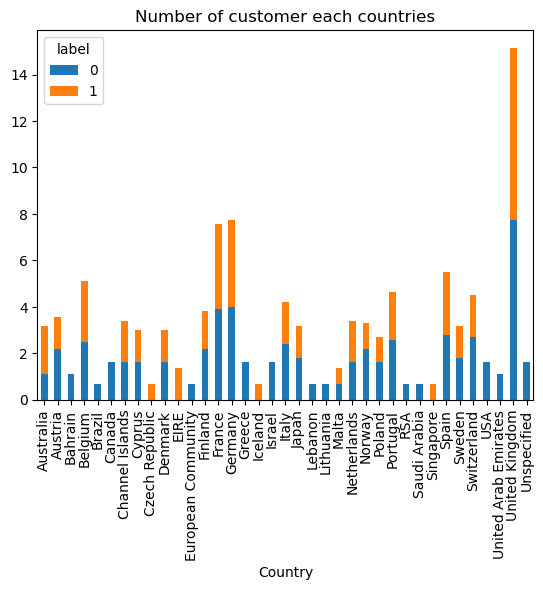

In [989]:
grouped_data = analyse_data1.groupby(['Country', 'label'])['CustomerID'].count().unstack()
grouped_data.apply(np.log1p).plot(kind='bar', stacked=True)
plt.title('Number of customer each countries')

We continue to visualize each clusters by countries and see that for each countries the ratio of 2 cluster is fairly balanced. Most of the customers are from Western countries with the highest spending countries are UK, France, Germany,..

After the data transformation, manipulation and applying unsupervised machine learning model we have successfully categorized customers into 2 distinct segmentations with different characteristics. This insight could contribute to future analyse or decision making process of the business

# Thank you for reviewing my project 